In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import parmed as pmd
import pytraj as pt
import numpy as np
import paprika
print('version: '+paprika.__version__)
from paprika import align
from paprika import tleap
from paprika import dummy
from paprika import restraints
from paprika import analysis
from paprika import amber
from paprika import utils
import os
import sys
import shutil
import re

import logging as log
reload(log)
log.basicConfig(format='%(asctime)s %(message)s', datefmt='%Y-%m-%d %I:%M:%S %p',
                filename='log.Analysis', level=log.DEBUG)
log.debug('test')

version: 2018-05-03_13:45:56_-0700-6311f4d-0.0.3


In [2]:
### Some initial CB8 stuff

# tleap command lines that build your structure
tleap_lines = [
    'source leaprc.water.tip3p',
    'loadamberparams ions.frcmod',
    'loadamberparams hst.frcmod',
    'HST = loadmol2 hst.mol2',
    'loadamberparams gst.frcmod',
    'GST = loadmol2 gst.mol2',
    'loadamberparams dummy.frcmod',
    'DM1 = loadmol2 dm1.mol2',
    'DM2 = loadmol2 dm2.mol2',
    'DM3 = loadmol2 dm3.mol2',
    'model = loadpdb hst-gst-dum.pdb',
]

tleap_build_files = ['ions.frcmod', 'hst.mol2','hst.frcmod','gst.mol2','gst.frcmod',
                     'dummy.frcmod', 'dm1.mol2', 'dm2.mol2', 'dm3.mol2']

guest_mask = ':GST'
host_oxy_side1 = ':HST@O9,O10,O11,O12,O13,O14,O15,O16'
host_oxy_side2 = ':HST@O1,O2,O3,O4,O5,O6,O7,O8'

# Anchor atoms
host_anch  = [':HST@C2', ':HST@C8', ':HST@C16']
guest_anch = [':GST@C17', ':GST@N2']
dummy_anch = [':DM1', ':DM2', ':DM3']

# Guest restraint details
attach_fractions = [0.0000, 0.0040, 0.0080, 0.0160, 0.0240, 0.0400, 0.0550, 0.0865, 0.1180, 0.1810, 0.2440, 0.3700, 0.4960, 0.7480, 1.0000]
num_attach_windows = len(attach_fractions)
attach_dist_fc = 5.0 # kcal/mol-Angstrom**2
attach_dist_target = 6.0 # Angstrom
pull_dist_target = 24.0 # Angstrom
pull_dist_incr = 0.4 # Angstrom
num_pull_windows = int(1. + (pull_dist_target-attach_dist_target)/pull_dist_incr )
attach_ang_fc = 100 # kcal/mol-rad**2
attach_ang_target = 180.0 # degrees
pull_ang_target = 180.0 # degrees
num_release_windows = 0

In [3]:
# Process each CB8/G3 conformation: align, write pdb, mol2, frcmod
hg_parms = []
for i_conf in range(1):
    conf_name = 'CB8-G3-'+str(i_conf)
    
    # Load pmd AmberParm
    prmtop = './SAMPL6/host_guest/SAMPLing/'+conf_name+'/AMBER/complex.prmtop'
    rst7 = './SAMPL6/host_guest/SAMPLing/'+conf_name+'/AMBER/complex.rst7'
    pmd_parm = pmd.amber.AmberParm(prmtop, xyz=rst7)
    
    # Align by CB8 oxygens. note conf 3 is reversed.
    hg_parm = pmd_parm[':HST,GST']
    if i_conf == 3:
        hg_parm = align.zalign(hg_parm, host_oxy_side2, host_oxy_side1)
    else:
        hg_parm = align.zalign(hg_parm, host_oxy_side1, host_oxy_side2)

    # Add dummy atoms
    hg_parm = dummy.add_dummy(hg_parm, residue_name='DM1', z=-3.500)
    hg_parm = dummy.add_dummy(hg_parm, residue_name='DM2', z=-6.500)
    hg_parm = dummy.add_dummy(hg_parm, residue_name='DM3', z=-8.700, y=2.200)
    hg_parms.append(hg_parm)
    

In [4]:
# Setup host restraints. Make a sublist for each conformation.
# Some format of this should become a function ...

host_rests = []

for i_conf in range(1):
    host_rests.append([])

    # Translational Distance
    host_rests[-1].append( restraints.static_DAT_restraint(
        [dummy_anch[0], host_anch[0]],
        [num_attach_windows, num_pull_windows, num_release_windows],
        hg_parms[i_conf],
        attach_dist_fc,
        amber_index=True
    ))

    # Translational Angle
    host_rests[-1].append( restraints.static_DAT_restraint(
        [dummy_anch[1], dummy_anch[0], host_anch[0]],
        [num_attach_windows, num_pull_windows, num_release_windows],
        hg_parms[i_conf],
        attach_ang_fc,
        amber_index=True
    ))

    # Translational Torsion
    host_rests[-1].append( restraints.static_DAT_restraint(
        [dummy_anch[2], dummy_anch[1], dummy_anch[0], host_anch[0]],
        [num_attach_windows, num_pull_windows, num_release_windows],
        hg_parms[i_conf],
        attach_ang_fc,
        amber_index=True
    ))

    # Orientational Angle 1
    host_rests[-1].append( restraints.static_DAT_restraint(
        [dummy_anch[0], host_anch[0], host_anch[1]],
        [num_attach_windows, num_pull_windows, num_release_windows],
        hg_parms[i_conf],
        attach_ang_fc,
        amber_index=True
    ))

    # Orientational Torsion 1
    host_rests[-1].append( restraints.static_DAT_restraint(
        [dummy_anch[1], dummy_anch[0], host_anch[0], host_anch[1]],
        [num_attach_windows, num_pull_windows, num_release_windows],
        hg_parms[i_conf],
        attach_ang_fc,
        amber_index=True
    ))

    # Orientational Torsion 2
    host_rests[-1].append( restraints.static_DAT_restraint(
        [dummy_anch[0], host_anch[0], host_anch[1], host_anch[2]],
        [num_attach_windows, num_pull_windows, num_release_windows],
        hg_parms[i_conf],
        attach_ang_fc,
        amber_index=True
    ))


In [5]:
# Setup guest restraints

guest_rests = []

for i_conf in range(1):
    guest_rests.append([]) 
    
    # Guest Translational Distance
    guest_rests[i_conf].append(restraints.DAT_restraint())
    guest_rests[i_conf][-1].auto_apr = False
    guest_rests[i_conf][-1].amber_index = True
    guest_rests[i_conf][-1].topology = hg_parms[i_conf]
    guest_rests[i_conf][-1].mask1 = dummy_anch[0]
    guest_rests[i_conf][-1].mask2 = guest_anch[0]
    guest_rests[i_conf][-1].attach['target'] = attach_dist_target
    guest_rests[i_conf][-1].attach['fraction_list'] = attach_fractions
    guest_rests[i_conf][-1].attach['fc_final'] = attach_dist_fc
    guest_rests[i_conf][-1].pull['fc'] = attach_dist_fc
    guest_rests[i_conf][-1].pull['target_initial'] = attach_dist_target
    guest_rests[i_conf][-1].pull['target_final'] = pull_dist_target
    guest_rests[i_conf][-1].pull['num_windows'] = num_pull_windows
    guest_rests[i_conf][-1].initialize()

    # Guest Translational Angle
    guest_rests[i_conf].append(restraints.DAT_restraint())
    guest_rests[i_conf][-1].auto_apr = False
    guest_rests[i_conf][-1].amber_index = True
    guest_rests[i_conf][-1].topology = hg_parms[i_conf]
    guest_rests[i_conf][-1].mask1 = dummy_anch[1]
    guest_rests[i_conf][-1].mask2 = dummy_anch[0]
    guest_rests[i_conf][-1].mask3 = guest_anch[0]
    guest_rests[i_conf][-1].attach['target'] = attach_ang_target
    guest_rests[i_conf][-1].attach['fraction_list'] = attach_fractions
    guest_rests[i_conf][-1].attach['fc_final'] = attach_ang_fc
    guest_rests[i_conf][-1].pull['fc'] = attach_ang_fc
    guest_rests[i_conf][-1].pull['target_initial'] = pull_ang_target
    guest_rests[i_conf][-1].pull['target_final'] = pull_ang_target
    guest_rests[i_conf][-1].pull['num_windows'] = num_pull_windows
    guest_rests[i_conf][-1].initialize()

    # Guest Orientational Angle
    guest_rests[i_conf].append(restraints.DAT_restraint())
    guest_rests[i_conf][-1].auto_apr = False
    guest_rests[i_conf][-1].amber_index = True
    guest_rests[i_conf][-1].topology = hg_parms[i_conf]
    guest_rests[i_conf][-1].mask1 = dummy_anch[0]
    guest_rests[i_conf][-1].mask2 = guest_anch[0]
    guest_rests[i_conf][-1].mask3 = guest_anch[1]
    guest_rests[i_conf][-1].attach['target'] = attach_ang_target
    guest_rests[i_conf][-1].attach['fraction_list'] = attach_fractions
    guest_rests[i_conf][-1].attach['fc_final'] = attach_ang_fc
    guest_rests[i_conf][-1].pull['fc'] = attach_ang_fc
    guest_rests[i_conf][-1].pull['target_initial'] = pull_ang_target
    guest_rests[i_conf][-1].pull['target_final'] = pull_ang_target
    guest_rests[i_conf][-1].pull['num_windows'] = num_pull_windows
    guest_rests[i_conf][-1].initialize()

# Make window list
window_list = restraints.create_window_list(guest_rests[0])

mbar-block CB8-G3-1/windows: A: 6.93 (0.16)  P: 10.05 (0.22) R: 0.00 (0.00) Std: -7.14 Total -4.02 (0.27)
ti-block CB8-G3-1/windows: A: 6.91 (0.21)  P: 10.06 (0.40) R: 0.00 (0.00) Std: -7.14 Total -3.99 (0.45)


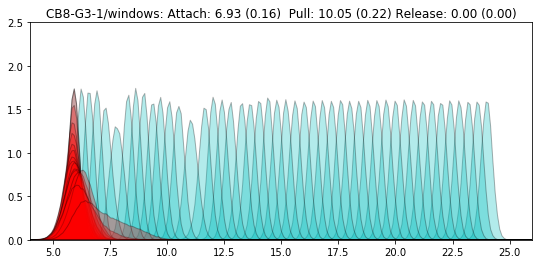

In [7]:
#Run Analysis

# Setup plot
fig,axs = plt.subplots(figsize=(9,4))
axis = [4.0,26.0,0.0,2.5]
zorder = len(window_list)+2

fecalc = analysis.fe_calc()
fecalc.prmtop = 'vac.prmtop'
fecalc.trajectory = 'prod.*.nc'
fecalc.path = os.path.join('CB8-G3-1','windows')
fecalc.restraint_list = guest_rests[i_conf]
fecalc.methods = ['mbar-block', 'ti-block']
fecalc.quicker_ti_matrix = True
fecalc.bootcycles = 1000
fecalc.collect_data()
fecalc.compute_free_energy()
fecalc.compute_ref_state_work([guest_rests[i_conf][0],guest_rests[i_conf][1],None,None,guest_rests[i_conf][2],None])
for meth in fecalc.methods:
    print('{} {}: A: {:.2f} ({:.2f})  P: {:.2f} ({:.2f}) R: {:.2f} ({:.2f}) Std: {:.2f} Total {:.2f} ({:.2f})'.format(
        meth,
        fecalc.path,
        fecalc.results['attach'][meth]['fe'],
        fecalc.results['attach'][meth]['sem'],
        fecalc.results['pull'][meth]['fe'],
        fecalc.results['pull'][meth]['sem'],
        0.0,
        0.0,
        fecalc.results['ref_state_work'],
        -1.0*fecalc.results['attach'][meth]['fe']+fecalc.results['pull'][meth]['fe']+fecalc.results['ref_state_work'],
        np.sqrt(fecalc.results['attach'][meth]['sem']**2 + fecalc.results['pull'][meth]['sem']**2),
    ))

       
# Update our plot.
axs.clear()
axs.axis(axis)
axs.set_title('{}: Attach: {:.2f} ({:.2f})  Pull: {:.2f} ({:.2f}) Release: {:.2f} ({:.2f})'.format(
    fecalc.path,
    fecalc.results['attach']['mbar-block']['fe'],
    fecalc.results['attach']['mbar-block']['sem'],
    fecalc.results['pull']['mbar-block']['fe'],
    fecalc.results['pull']['mbar-block']['sem'],
    0.0,
    0.0,
))
for phase in 'attach pull'.split():                    
    for i in range(len(fecalc.simulation_data[phase])):
        hist,bins = np.histogram(
                        fecalc.simulation_data[phase][i][0],
                        bins=301,
                        range=(0,30),
                        density=True
                    )
        center = (bins[:-1] + bins[1:]) / 2
        if phase == 'attach' or phase == 'release':
            facecolor = 'r'
        else:
            facecolor = 'c'
        axs.fill_between(
            center, hist*0.0, hist, facecolor=facecolor, edgecolor='k',
            alpha=0.3, zorder=zorder
        )
        zorder -= 1
    fig.canvas.draw()
            
